In [1]:
import pickle
import pandas as pd
import numpy as np
from skimage.transform import resize
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

In [2]:
###Import the two pickle files to be worked on

# Pickle files to be merged
fullscale_path = r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\cellPose_btrack_regionprops_fullScale_variance.pkl'
tracked_path = r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\cellPose_btrack_regionprops_Maddie_Tracked.pkl'

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

fullscale_untracked = load_pickle(fullscale_path)
downscaled_tracked = load_pickle(tracked_path)

#Confirm that the pickles loaded and show the expected contents
print("Fullscale Contents:")
print(fullscale_untracked)

print("\nDownscaled Contents:")
print(downscaled_tracked)

Fullscale Contents:
        label  area    centroid-0    centroid-1  orientation  \
0          10  1508     23.532493   4452.986074    -0.624003   
1          11  2746     30.155499   6911.299345     1.383103   
2          12  2314     31.873379   9916.277010    -0.297126   
3          13  1586     29.944515   3941.948298     0.273103   
4          14   584     16.878425   5192.186644    -1.345791   
...       ...   ...           ...           ...          ...   
675118   3774  1594  13378.752196   6713.555207    -0.668165   
675119   3775  1129  13385.292294  10883.574845    -0.199021   
675120   3778  1850  13400.852973   3086.363784    -1.074672   
675121   3779  1830  13407.815847   9654.990164    -1.318282   
675122   3785   487  13422.314168  10191.365503     1.446497   

        major_axis_length  minor_axis_length  bbox-0  bbox-1  bbox-2  ...  \
0               53.604304          35.943391       1    4431      48  ...   
1               61.117411          57.323003       2    6

In [3]:
# Extract the mask from "image" and the intensity array from "image_intensity"
image_mask = fullscale_untracked['image']
image_intensity = fullscale_untracked['image_intensity']

# Calculate variances 
row_variances = []
for i in range(image_mask.shape[0]):
    masked_pixels = image_intensity[i][image_mask[i]]
    row_variance = np.var(masked_pixels) if len(masked_pixels) > 0 else np.nan
    row_variances.append(row_variance)

# Convert to pandas dataframe and all calculated variances
fullscale_untracked_df = pd.DataFrame(fullscale_untracked)
fullscale_untracked_df['row_variance'] = row_variances

# Save everything so this step won't need to be repeated
#fullscale_untracked_df.to_pickle(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\cellPose_btrack_regionprops_fullScale_variance_calculated.pkl')
#fullscale_untracked_df.to_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\cellPose_btrack_regionprops_fullScale_variance_calculated.csv', index=False)
#print("Data saved")


In [4]:
# Scaling the "area" column by a factor of 4
downscaled_tracked['area'] = downscaled_tracked['area'] * 4

# Specify a list of columns to scale by a factor of 2
columns_to_upscale = ['centroid-0', 'centroid-1', 'major_axis_length', 'minor_axis_length', 'bbox-0', 'bbox-1', 'bbox-2',
       'bbox-3', 'centroid-0_ring', 'centroid-1_ring', 'size_x', 'size_y']

# Scale every value in the specified columns by a factor of 2
for column in columns_to_upscale:
    if column in downscaled_tracked:
        print(downscaled_tracked[column])
        downscaled_tracked[column] = downscaled_tracked[column] * 2
        print(downscaled_tracked[column])

def upscale_image(image, scale_factor=2):
    """Upscale a given image by a specified factor."""
    if not isinstance(image, np.ndarray) or image.ndim != 2:
        raise ValueError("Each image should be a 2D numpy array.")
    return resize(
        image,
        (image.shape[0] * scale_factor, image.shape[1] * scale_factor),
        order=0,  # Nearest neighbor interpolation for boolean arrays
        preserve_range=True,
        anti_aliasing=False
    ).astype(bool)

# Apply the resizing function to every image in the "image" column
downscaled_tracked['image'] = downscaled_tracked['image'].apply(upscale_image)

# Convert to a DataFrame and save
downscaled_upscaled_tracked_df = pd.DataFrame(downscaled_tracked)
#downscaled_upscaled_tracked_df.to_pickle(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\downscaled_upscaled_tracked.pkl')
#downscaled_upscaled_tracked_df.to_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\downscaled_upscaled_tracked.csv', index=False)

print("Data Saved")

0         4106.426150
1         4099.476965
2         4092.295890
3         4090.064067
4         4086.768194
             ...     
648668    3217.918306
648669    5824.926316
648670    5824.926316
648671    1438.012129
648672    1438.012129
Name: centroid-0, Length: 648673, dtype: float64
0          8212.852300
1          8198.953930
2          8184.591781
3          8180.128134
4          8173.536388
              ...     
648668     6435.836611
648669    11649.852632
648670    11649.852632
648671     2876.024259
648672     2876.024259
Name: centroid-0, Length: 648673, dtype: float64
0         3982.150121
1         3957.005420
2         3958.706849
3         3961.094708
4         3962.064690
             ...     
648668     950.549168
648669    1767.200000
648670    1767.200000
648671    1956.323450
648672    1956.323450
Name: centroid-1, Length: 648673, dtype: float64
0         7964.300242
1         7914.010840
2         7917.413699
3         7922.189415
4         7924.129380
      

In [5]:
import pandas as pd
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

# Add prefixes to ensure columns are distinct and identifiable
downscaled_upscaled_tracked_df = downscaled_upscaled_tracked_df.add_prefix('down_')
fullscale_untracked_df = fullscale_untracked_df.add_prefix('full_')

# Handle shared column names for 'centroid-0', 'centroid-1', and 't' by renaming them back to original
shared_columns = ['centroid-0', 'centroid-1', 't']
for col in shared_columns:
    downscaled_upscaled_tracked_df.rename(columns={'down_' + col: col}, inplace=True)
    fullscale_untracked_df.rename(columns={'full_' + col: col}, inplace=True)

# Prepare to merge
merged_rows = []
conflicting_matches = []

# Iterate through unique 't' values that appear in both dataframes
for t_value in set(downscaled_upscaled_tracked_df['t']).intersection(fullscale_untracked_df['t']):
    down_subset = downscaled_upscaled_tracked_df[downscaled_upscaled_tracked_df['t'] == t_value]
    full_subset = fullscale_untracked_df[fullscale_untracked_df['t'] == t_value]

    if down_subset.empty or full_subset.empty:
        continue

    distances = cdist(down_subset[['centroid-0', 'centroid-1']], full_subset[['centroid-0', 'centroid-1']])
    row_ind, col_ind = linear_sum_assignment(distances)

    for i, j in zip(row_ind, col_ind):
        down_row = down_subset.iloc[i]
        full_row = full_subset.iloc[j]

        # Keep only the necessary columns from the downscaled dataset and retain centroids from the full dataset
        down_row_cleaned = down_row.drop(['centroid-0', 'centroid-1', 't'])

        # Merge and keep track of potential conflicts
        if j in col_ind[:i]:  # Check for conflicts
            conflicting_matches.append((t_value, i, j))

        # Important: Include the full_row's centroids and time
        merged_row = pd.concat([down_row_cleaned, full_row], axis=0)
        merged_rows.append(merged_row)

# Concatenate all merged rows into a single DataFrame
merged_df = pd.concat(merged_rows, axis=1).transpose()

# Remove columns that are completely empty across all rows
merged_df.dropna(axis=1, how='all', inplace=True)

# Display the DataFrame and any conflicts
print(merged_df)
if conflicting_matches:
    print("Conflicts detected:", conflicting_matches)
else:
    print("No conflicts detected.")


       down_label down_area down_orientation down_major_axis_length  \
0            2236    2616.0        -0.739717              65.064118   
1            2224    1688.0         0.705534              54.761247   
2            2225    1816.0        -0.701948               57.73455   
3            2226    1776.0          0.15648              57.090164   
4            2227    1996.0         0.700828              66.381439   
...           ...       ...              ...                    ...   
648666       2706    2644.0              NaN                    NaN   
648667       1032    2660.0              NaN                    NaN   
648668       1032    2660.0              NaN                    NaN   
648669       1940    2968.0              NaN                    NaN   
648670       1940    2968.0              NaN                    NaN   

       down_minor_axis_length down_bbox-0 down_bbox-1 down_bbox-2 down_bbox-3  \
0                   51.355406        8214        9196        8274 

In [ ]:
merged_df.to_pickle(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\merged_df.pkl')
merged_df.to_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\merged_df.csv', index=False)

Start from here if already Merged

In [ ]:
###Reload from here to avoid running everything above again

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)
    
merged_path = r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\merged_df.pkl'

merged = load_pickle(merged_path)
merged_df = pd.DataFrame(merged)

In [6]:
merged_df.t

0           0
1           0
2           0
3           0
4           0
         ... 
648666    187
648667    187
648668    187
648669    187
648670    187
Name: t, Length: 648673, dtype: object

For Merging Track ID labels onto a 4i dataset

In [6]:
finished_4i_path = r'Z:\Garrett\Livecell\072723_50hr_20uM_TBHP\cell_data\cell_data_B03_df.csv'

finished_4i_df = pd.read_csv(finished_4i_path)

In [7]:
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

# Assuming you have already loaded your dataframes: merged_df (with track_id) and finished_4i_df (to be added to)

# Set the 't' variable at the start
t_value = 187  # Replace with the desired value of 't'

# Handle shared column names for 'centroid-0' and 'centroid-1' by renaming them back to original
shared_columns = ['centroid-0', 'centroid-1']
for col in shared_columns:
    merged_df.rename(columns={'down_' + col: col}, inplace=True)
    finished_4i_df.rename(columns={'full_' + col: col}, inplace=True)

# Ensure 'centroid-0' and 'centroid-1' are numeric
merged_df['centroid-0'] = pd.to_numeric(merged_df['centroid-0'], errors='coerce')
merged_df['centroid-1'] = pd.to_numeric(merged_df['centroid-1'], errors='coerce')
finished_4i_df['centroid-0'] = pd.to_numeric(finished_4i_df['centroid-0'], errors='coerce')
finished_4i_df['centroid-1'] = pd.to_numeric(finished_4i_df['centroid-1'], errors='coerce')

# Drop rows with NaNs in 'centroid-0' and 'centroid-1' after conversion
merged_df.dropna(subset=['centroid-0', 'centroid-1'], inplace=True)
finished_4i_df.dropna(subset=['centroid-0', 'centroid-1'], inplace=True)

# Prepare to merge
final_rows = []
conflicting_matches = []

# Subset merged_df based on the specified 't' value
down_subset = merged_df[merged_df['t'] == t_value]
full_subset = finished_4i_df  # No need to subset finished_4i_df as it doesn't have 't' column

if not down_subset.empty and not full_subset.empty:
    distances = cdist(down_subset[['centroid-0', 'centroid-1']], full_subset[['centroid-0', 'centroid-1']])
    row_ind, col_ind = linear_sum_assignment(distances)

    for i, j in zip(row_ind, col_ind):
        down_row = down_subset.iloc[i]
        full_row = full_subset.iloc[j]

        # Keep only the necessary columns from the merged_df dataset
        down_row_cleaned = down_row.drop(['centroid-0', 'centroid-1', 't'])

        # Ensure track_id and down_accepted exist in down_row_cleaned
        if 'down_track_id' not in down_row_cleaned or 'down_accepted' not in down_row_cleaned:
            raise KeyError(f"Required columns not found in down_row_cleaned. Available columns are: {down_row_cleaned.index.tolist()}")

        # Merge and keep track of potential conflicts
        if j in col_ind[:i]:  # Check for conflicts
            conflicting_matches.append((t_value, i, j))

        # Combine rows from down_row_cleaned and full_row
        full_row_with_track_id = full_row.copy()
        full_row_with_track_id['track_id'] = down_row_cleaned['down_track_id']
        full_row_with_track_id['down_accepted'] = down_row_cleaned['down_accepted']

        final_rows.append(full_row_with_track_id)

# Concatenate all merged rows into a single DataFrame
if final_rows:
    finished_4i_df_with_track_id = pd.concat(final_rows, axis=1).transpose()
    # Remove columns that are completely empty across all rows
    finished_4i_df_with_track_id.dropna(axis=1, how='all', inplace=True)

    # Display the DataFrame and any conflicts
    print(finished_4i_df_with_track_id)
else:
    print("No data to merge for t =", t_value)

if conflicting_matches:
    print("Conflicts detected:", conflicting_matches)
else:
    print("No conflicts detected.")

finished_4i_df_with_track_id.to_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\finished_4i_df_with_track_id.csv', index=False)


     Unnamed: 0 label nuc_area   centroid-0   centroid-1 orientation  \
1924       1965  1976      746  3098.226542  3697.654155   -0.785624   
3227       3306  3317      589  5486.203735  5429.847199      1.1024   
2816       2889  2900      882  4724.413832   569.056689    0.734533   
1957       1998  2009      495  3154.769697  3779.242424   -0.236634   
3323       3403  3414      731   5685.28591  2038.730506    0.060003   
...         ...   ...      ...          ...          ...         ...   
2340       2397  2408      679  3824.799705  1010.758468   -1.388982   
2869       2944  2955      683  4813.575403  1574.553441    1.561909   
3126       3204  3215      892  5295.754484  1575.150224    0.519304   
1659       1692  1703      429  2681.937063  3557.403263    0.937542   
1471       1498  1509      672  2384.233631  3579.452381   -1.448721   

     major_axis_length minor_axis_length bbox-0 bbox-1  ...  \
1924         39.238953         24.244151   3082   3682  ...   
3227     

Centroid for Z:\Garrett\Livecell\072723_50hr_20uM_TBHP\livecell_B03\slices\slice_T187_C0.tif: [6482.56351039 3494.02540416]
Centroid for Z:\Garrett\Livecell\072723_50hr_20uM_TBHP\livecell_B03\full\data\last_frame_fullscale.tif: [12993.28785358  6966.35662784]
Centroid for C:\Users\gases\Desktop\050924_IDmerge_varcalc\finished_4i_DNA.tif: [6268.56091954 4400.23908046]


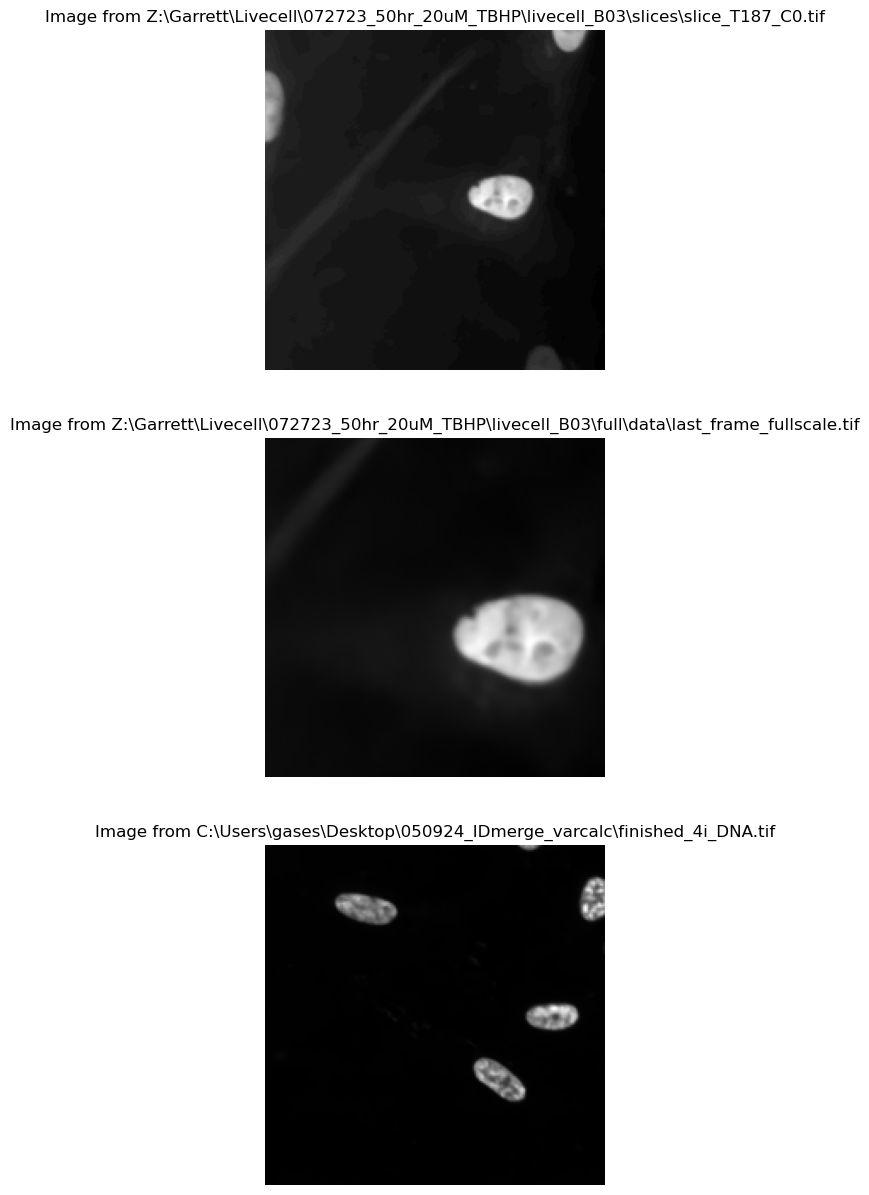

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import pickle

# Sample crop_image function
def crop_image(img, centroid, size):
    half_size = size // 2
    x, y = int(centroid[0]), int(centroid[1])
    return img[y-half_size:y+half_size, x-half_size:x+half_size]

# Function to retrieve the centroid for the given down_track_id from a dataframe
def get_centroid(df, down_track_id):
    if 'down_track_id' in df.columns:
        row = df[df['down_track_id'] == down_track_id]
    elif 'track_id' in df.columns:
        row = df[df['track_id'] == down_track_id]
    else:
        return None
    if not row.empty:
        return row[['centroid-0', 'centroid-1']].values[0]
    return None

# Function to process and display images
def validate_down_track_id(down_track_id, dataframes, image_files, crop_size=200):
    centroids = []
    cropped_images = []
    
    for df in dataframes:
        centroid = get_centroid(df, down_track_id)
        if centroid is not None:
            centroids.append(centroid)
        else:
            print(f"down_track_id {down_track_id} not found in one of the dataframes.")
            return

    for img_file, centroid in zip(image_files, centroids):
        img = imread(img_file)
        cropped_img = crop_image(img, centroid, crop_size)
        cropped_images.append(cropped_img)
        print(f"Centroid for {img_file}: {centroid}")

    # Display the images stacked vertically
    fig, axes = plt.subplots(len(cropped_images), 1, figsize=(5, 15))
    if len(cropped_images) == 1:
        axes = [axes]  # Ensure axes is a list when there's only one image
    for ax, cropped_img, img_file in zip(axes, cropped_images, image_files):
        ax.imshow(cropped_img, cmap='gray')
        ax.set_title(f"Image from {img_file}")
        ax.axis('off')
    plt.show()

# Example usage

def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

downscaled_df = load_pickle(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\cellPose_btrack_regionprops_Maddie_Tracked.pkl')
fullscale_tracked_df = pd.read_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\merged_df.csv')
finished_4i_df_with_track_id = pd.read_csv(r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\finished_4i_df_with_track_id.csv')
dataframes = [downscaled_df, fullscale_tracked_df, finished_4i_df_with_track_id]

###Image order here is the same as the order of the dataframes above
###You'll need to manually prepare the images that feed into this, as it is expecting a single frame, single channel image for each
image_files = [(r'Z:\Garrett\Livecell\072723_50hr_20uM_TBHP\livecell_B03\slices\slice_T187_C0.tif')
               , (r'Z:\Garrett\Livecell\072723_50hr_20uM_TBHP\livecell_B03\full\data\last_frame_fullscale.tif')
               , (r'C:\Users\gases\Desktop\050924_IDmerge_varcalc\finished_4i_DNA.tif')]

down_track_id = 1051  # Replace with the actual down_track_id you want to validate
validate_down_track_id(down_track_id, dataframes, image_files)


In [10]:
# Filter the dataframe to get rows where 'down_down_accepted' is True
accepted_tracks = merged_df[merged_df['down_accepted']]

# Get the unique values of 'down_down_track_id' from the filtered dataframe
unique_track_ids = accepted_tracks['down_track_id'].unique()

# Print or return the list of unique track ids
print(unique_track_ids)
len(unique_track_ids)


[4.0 11.0 22.0 34.0 35.0 76.0 86.0 114.0 121.0 133.0 143.0 148.0 178.0
 202.0 208.0 213.0 226.0 230.0 245.0 247.0 248.0 250.0 252.0 255.0 263.0
 264.0 277.0 282.0 285.0 307.0 331.0 360.0 361.0 399.0 403.0 404.0 429.0
 438.0 444.0 456.0 457.0 494.0 506.0 543.0 594.0 603.0 620.0 626.0 649.0
 653.0 662.0 683.0 704.0 724.0 751.0 754.0 760.0 797.0 800.0 817.0 819.0
 839.0 840.0 853.0 859.0 863.0 868.0 876.0 878.0 883.0 890.0 892.0 895.0
 903.0 907.0 920.0 925.0 930.0 947.0 953.0 961.0 965.0 979.0 984.0 985.0
 999.0 1014.0 1021.0 1032.0 1033.0 1039.0 1045.0 1051.0 1055.0 1058.0
 1062.0 1067.0 1075.0 1076.0 1078.0 1102.0 1121.0 1126.0 1133.0 1139.0
 1141.0 1142.0 1146.0 1147.0 1152.0 1155.0 1172.0 1175.0 1186.0 1192.0
 1195.0 1203.0 1205.0 1209.0 1214.0 1234.0 1239.0 1244.0 1251.0 1264.0
 1283.0 1298.0 1300.0 1307.0 1309.0 1321.0 1331.0 1336.0 1343.0 1362.0
 1368.0 1373.0 1396.0 1404.0 1417.0 1439.0 1441.0 1467.0 1476.0 1477.0
 1485.0 1497.0 1504.0 1507.0 1508.0 1509.0 1510.0 1513.0 1515.0 15

494

In [ ]:
import matplotlib.pyplot as plt

# Specify the track_id and column you want to plot
track_id = 1535
column_to_plot = 'full_row_variance'

# Filter the DataFrame for the specified track_id
filtered_df = merged_df[merged_df['down_track_id'] == track_id]

# Ensure the data is sorted by time to make the plot meaningful
filtered_df = filtered_df.sort_values(by='t')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['t'], filtered_df[column_to_plot], marker='o')
plt.title(f'Time Series Plot of {column_to_plot} for Track ID {track_id}')
plt.xlabel('Time (t)')
plt.ylabel(column_to_plot)
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Specify the column you want to plot
column_to_plot = 'full_row_variance'

# Filter the DataFrame to get rows where 'down_down_accepted' is True
accepted_tracks = merged_df[merged_df['down_accepted']]

# Get the unique values of 'down_down_track_id' from the filtered dataframe
unique_track_ids = accepted_tracks['down_track_id'].unique()

# Print or return the list of unique track ids
print("Unique Track IDs:", unique_track_ids)
print("Number of Unique Track IDs:", len(unique_track_ids))

# Setup plot
plt.figure(figsize=(12, 8))

# Iterate over each track ID and plot
for track_id in unique_track_ids:
    # Filter the DataFrame for the specified track_id
    filtered_df = merged_df[merged_df['down_track_id'] == track_id]

    # Ensure the data is sorted by time to make the plot meaningful
    filtered_df = filtered_df.sort_values(by='t')

    # Plotting for each track_id
    plt.plot(filtered_df['t'], filtered_df[column_to_plot], marker='o', label=f'Track ID {track_id}')

# Finalize the plot
plt.title(f'Time Series Plot of {column_to_plot} for All Accepted Tracks')
plt.xlabel('Time (t)')
plt.ylabel(column_to_plot)
plt.grid(True)
plt.legend()  # Show legend to identify tracks
plt.show()
